# Flux Balance Analysis (FBA)
 
Flux Balance Analysis (FBA) is a computational method used primarily in systems biology and metabolic engineering. It's a way to understand and predict the flow or "flux" of metabolites in a metabolic network under certain conditions.

In this tutorial, we will see how to create FBA problems with CORNETO for metabolic analysis, how CORNETO can interoperate with other FBA-based libraries such as COBRApy or MIOM, and how CORNETO's FBA problem can be used as a building block for more advanced FBA methods. 

## What is FBA?

The basis of FBA lies in the principle of steady-state, where the concentration of internal metabolites doesn't change over time even though they may be consumed and produced. This means that the total rate at which a metabolite is produced equals the rate at which it's consumed. 

In the realm of metabolic network analysis, this concept translates to steady-state metabolic fluxes. A flux is a rate at which a substance moves through a system, and in metabolic systems, flux represents the rate of turnover of a metabolite through a specific pathway or reaction. When considering the steady-state, each reaction's flux in the metabolic network is balanced, meaning that, for every internal metabolite, the sum of fluxes leading to its production is equal to the sum of fluxes leading to its consumption. This balance ensures that, over time, there's no accumulation or depletion of any metabolite in the system.

For quantifying these fluxes, the typical units used are millimoles per gram dry weight per hour (mmol/gDW/h). The "mmol" part represents the quantity of the metabolite, the "gDW" (gram dry weight) normalizes this value to the biomass of the organism, and the "/h" provides a temporal dimension, indicating how fast the metabolic turnover occurs. This unit allows researchers and practitioners to make meaningful comparisons across different metabolic systems and conditions. For example, a flux value of 5 mmol/gDW/h for a particular reaction indicates that 5 millimoles of the relevant metabolite are produced or consumed per gram of the organism's dry weight every hour.

<center style="margin:25px">
    <img src="https://www.biorxiv.org/content/biorxiv/early/2016/05/15/053520/F1.large.jpg" alt="Flux Balance Analysis" style="width: 100%; max-width:500px; margin-bottom:10px;">
    <br>
    <font size="-1">
        <b>Figure 1:</b> Vivek-Ananth, R. P., and Areejit Samal. "Advances in the integration of transcriptional regulatory information into genome-scale metabolic models." Biosystems 147 (2016): 1-10.
    </font>
</center>



## FBA with CORNETO

In order to define a FBA problem, you need to know the following:

- **Genome-scale metabolic network**: This is the prior knowledge, usually known as genome-scale metabolic models (GEMs). These models represent the metabolic network through a stoichiometric matrix, where each row represents a metabolite and each column represents a reaction. The entries in the matrix are the stoichiometric coefficients of the metabolites in the reactions. These models also contain annotations such as Gene-Protein-Rules (GPRs) and default reaction bounds.

- **Constraints**: For each reaction, there are limits or "constraints" on the flux based on factors like enzyme capacities. Basically, it’s setting the maximum and minimum fluxes for the reactions.

- **Objective Function**: You then define an objective to optimize, like maximizing the production of a specific metabolite or maximizing growth rate.

- **Computational Solution**: Using linear programming techniques, you can find the flux distribution that meets the constraints and optimizes the objective function.


CORNETO naturally supports FBA-based problems by transforming a genome scale metabolic network into a prior knowledge graph, and then modelling the FBA problem as a network flow problem. This is the main building block for creating more complex problems, such as multicondition Sparse FBA or multicondition iMAT for context-specific reconstruction.


## Using COBRApy

Here we show how can we use COBRApy to import the `textbook` metabolic network and how can we import it in CORNETO. We will also compare the FBA solution from COBRApy and CORNETO.

In [1]:
import cobra
from cobra.io import load_model

model = load_model("textbook")
len(model.metabolites), len(model.reactions)

(72, 95)

In [2]:
biomass_rxn = model.reactions.get_by_id("Biomass_Ecoli_core")
biomass_rxn

Reaction identifier,Biomass_Ecoli_core
Name,Biomass Objective Function with GAM
Memory address,0x7fefbc1edfd0
Stoichiometry,1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0.361 e4p_c + 0.0709 f6p_c + 0.129 g3p_c + 0.205 g6p_c + 0.2557 gln__L_c + 4.9414 glu__L_c + 59.81 h2o_c + 3.547 nad_c + 13.0279 nadph_c + 1.7867 oaa_c... 1.496 3-Phospho-D-glycerate + 3.7478 Acetyl-CoA + 59.81 ATP + 0.361 D-Erythrose 4-phosphate + 0.0709 D-Fructose 6-phosphate + 0.129 Glyceraldehyde 3-phosphate + 0.205 D-Glucose 6-phosphate + 0.2557...
GPR,
Lower bound,0.0
Upper bound,1000.0


In [3]:
solution = model.optimize()
print(solution)

<Solution 0.874 at 0x7fefbc0acf50>



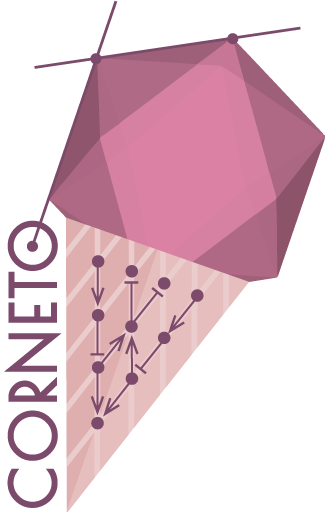

In [4]:
import corneto as cn
cn.info()

In [5]:
G = cn.Graph.from_cobra_model(model)
G.shape

(72, 95)

In [6]:
rid = list(G.get_edges_by_attr("id", biomass_rxn.id))[0]
G.get_attr_edge(rid)

{'__edge_type': 'directed',
 'id': 'Biomass_Ecoli_core',
 '__source_attr': {'3pg_c': {'__value': -1.496},
  'accoa_c': {'__value': -3.7478},
  'atp_c': {'__value': -59.81},
  'e4p_c': {'__value': -0.361},
  'f6p_c': {'__value': -0.0709},
  'g3p_c': {'__value': -0.129},
  'g6p_c': {'__value': -0.205},
  'gln__L_c': {'__value': -0.2557},
  'glu__L_c': {'__value': -4.9414},
  'h2o_c': {'__value': -59.81},
  'nad_c': {'__value': -3.547},
  'nadph_c': {'__value': -13.0279},
  'oaa_c': {'__value': -1.7867},
  'pep_c': {'__value': -0.5191},
  'pyr_c': {'__value': -2.8328},
  'r5p_c': {'__value': -0.8977}},
 '__target_attr': {'adp_c': {'__value': 59.81},
  'akg_c': {'__value': 4.1182},
  'coa_c': {'__value': 3.7478},
  'h_c': {'__value': 59.81},
  'nadh_c': {'__value': 3.547},
  'nadp_c': {'__value': 13.0279},
  'pi_c': {'__value': 59.81}},
 'default_lb': 0.0,
 'default_ub': 1000.0,
 'GPR': ''}

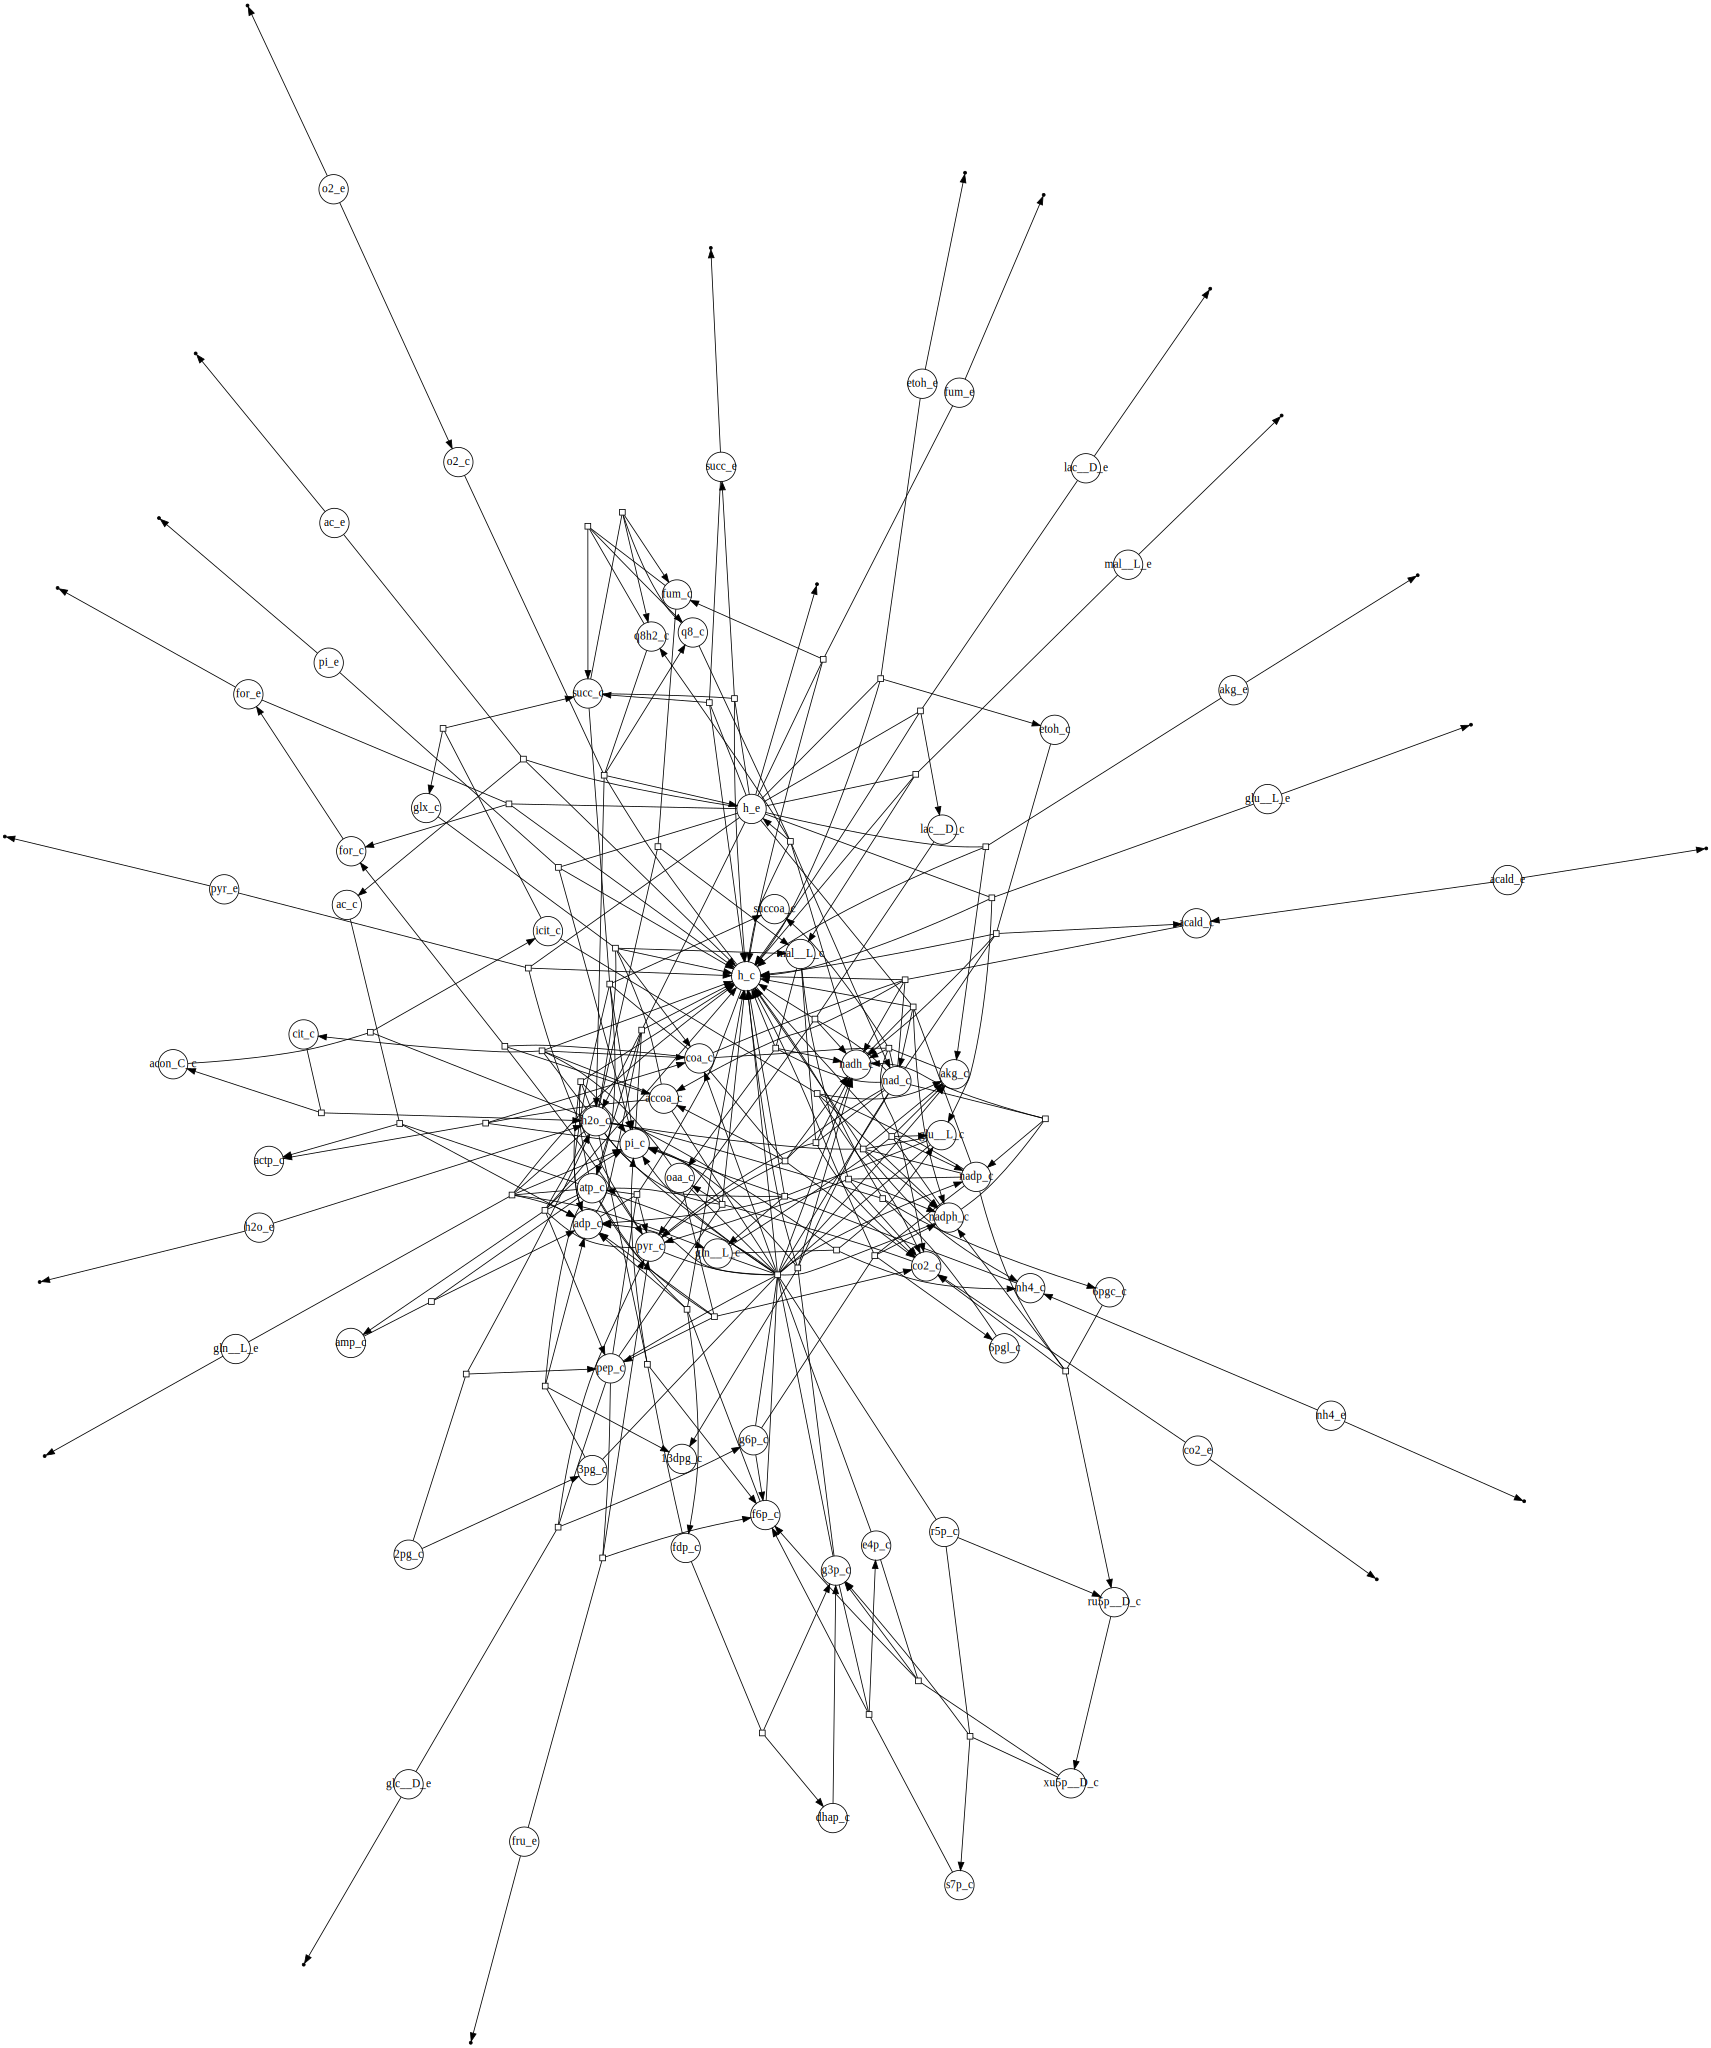

In [7]:
G.plot(layout="fdp")

In [8]:
from corneto.methods.metabolism.fba import fba_problem

P = fba_problem(G)
biomass = P.expr.flow[rid]
P.add_objectives(biomass, weights=-1)
P.solve()
print(biomass.value)

0.8739215069684303


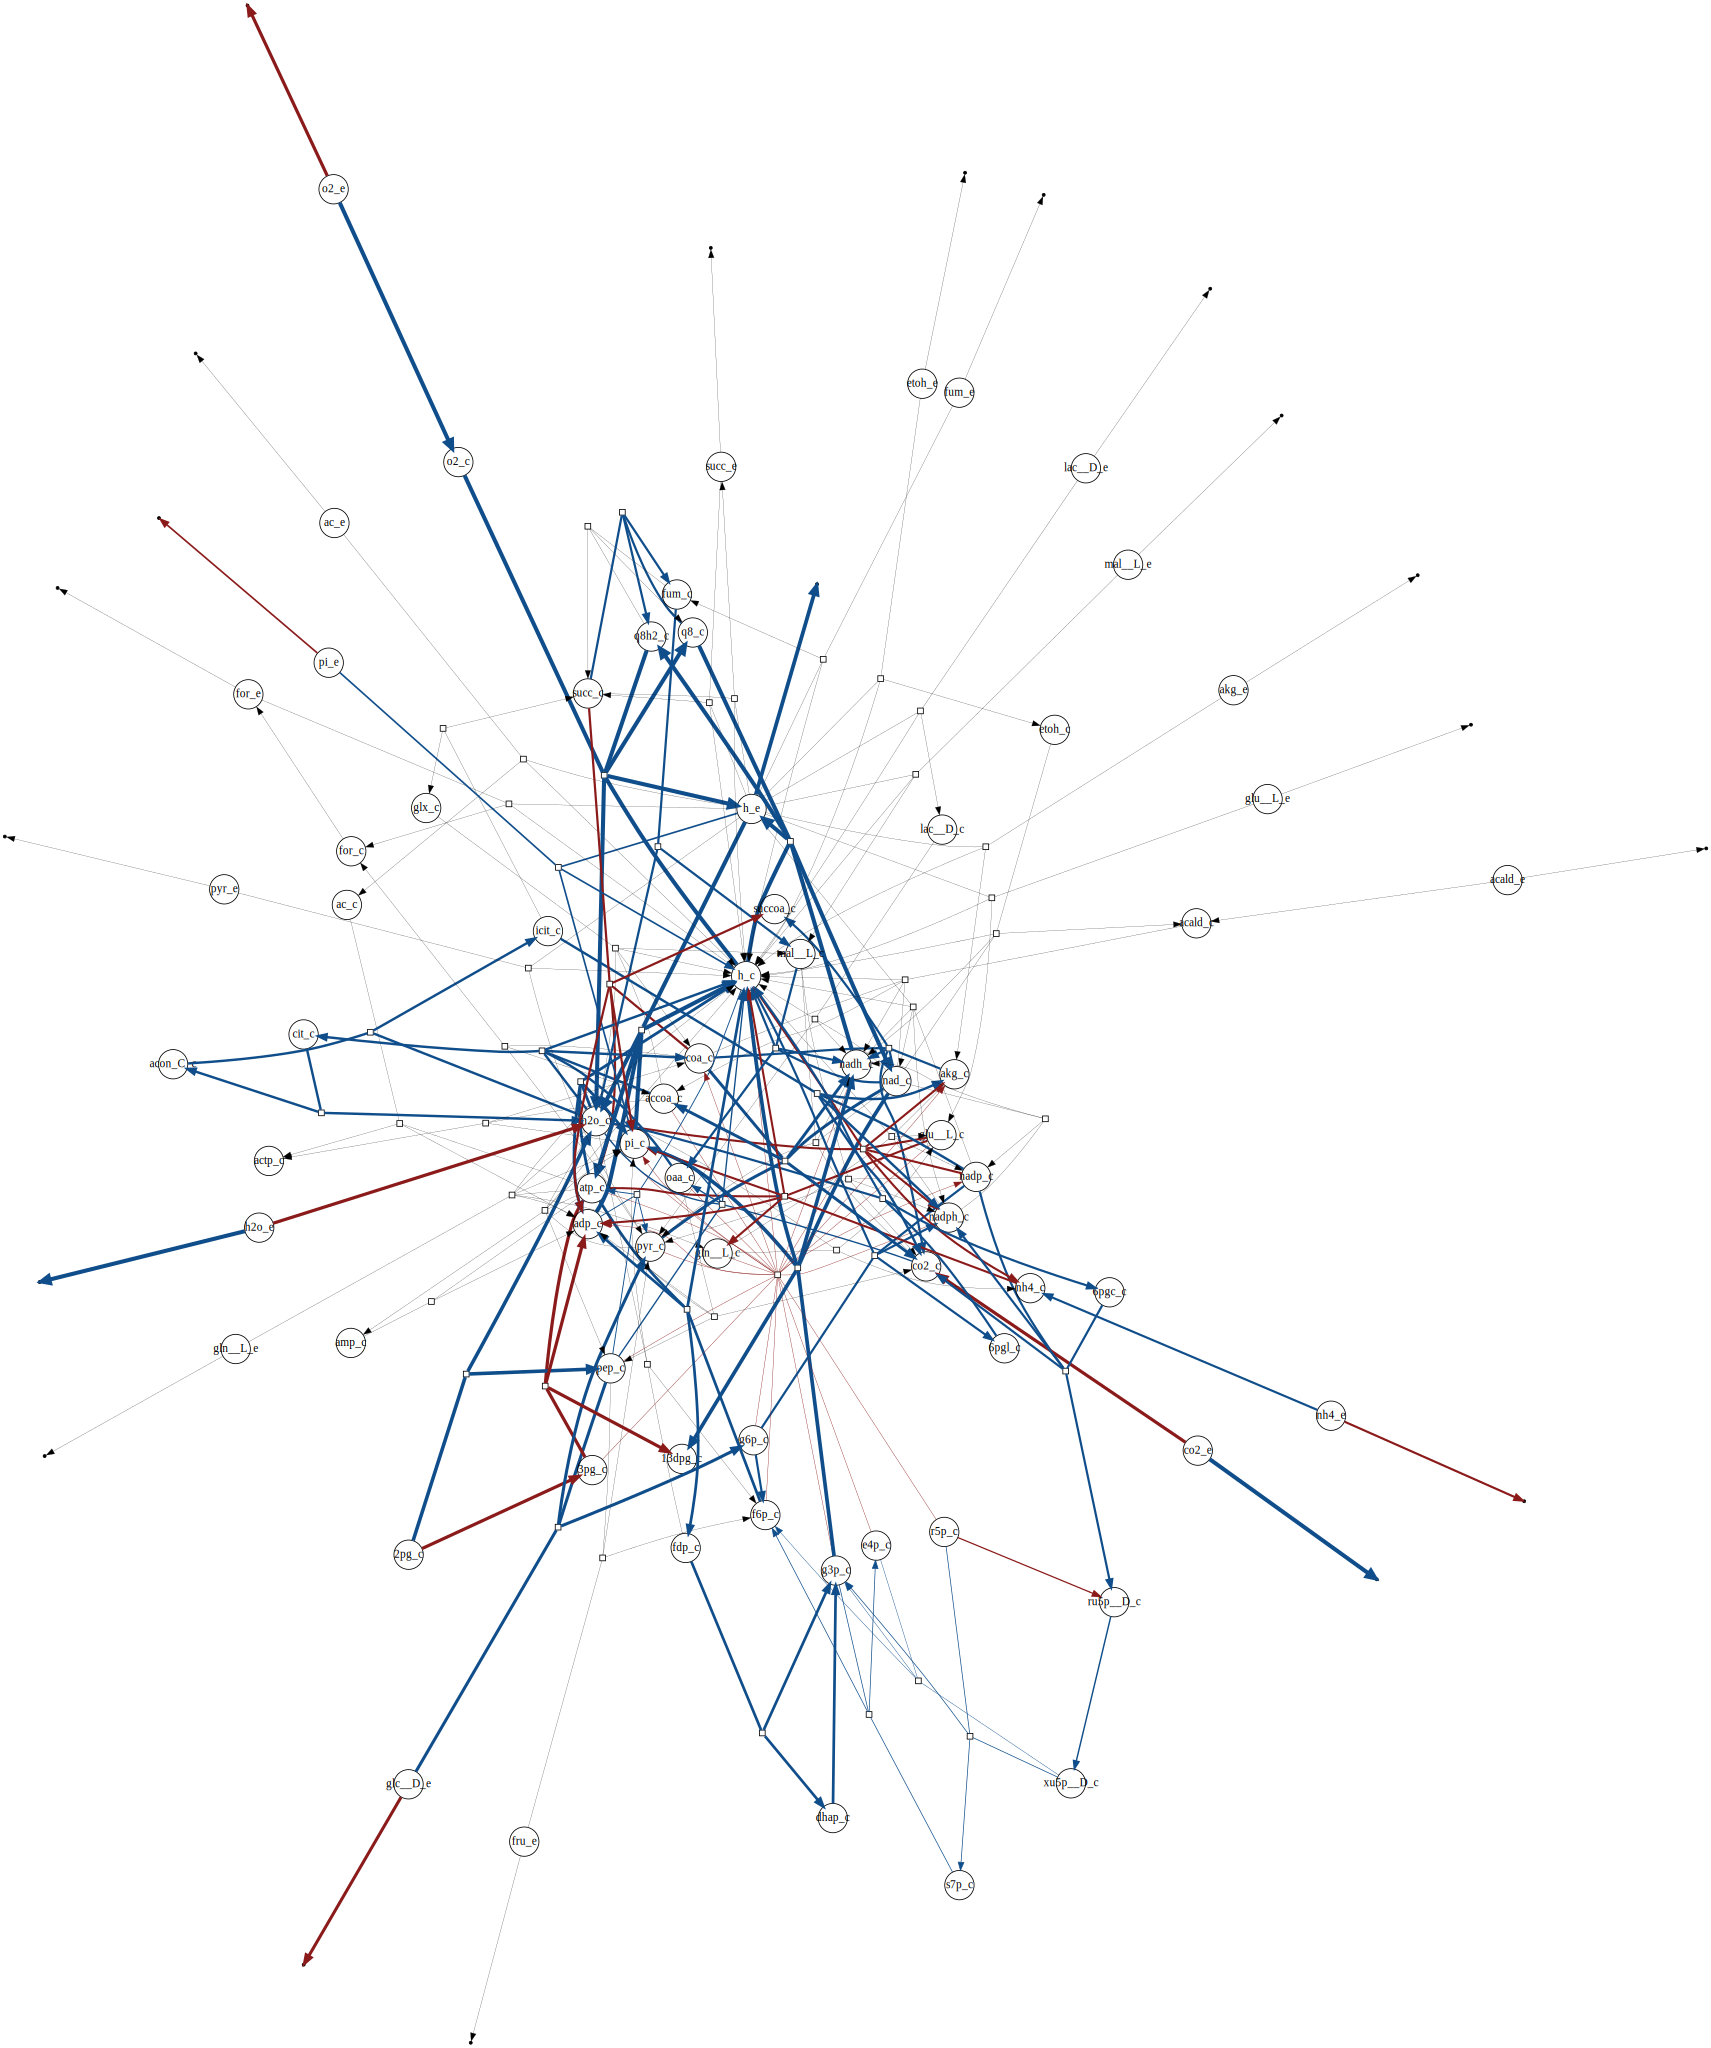

In [9]:
G.plot(custom_edge_attr=cn.pl.flow_style(P), layout="fdp")